In [1]:
from setup import dask_init, dask_shutdown
import dask.distributed as dd
import dask.dataframe as ddf
from tqdm import tqdm
import pickle

import pandas as pd
import numpy as np

import ingestion as ing
import processing as prc

import datetime as dt


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

# Setup

In [2]:
# PANDAS SETUP
pd.options.mode.use_inf_as_na = True

# DASK SETUP
client, cluster = dask_init()
cluster

c:\Users\Henrique\anaconda3\lib\site-packages\distributed\node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62184 instead
  warnings.warn(


# [I] Loading the data

In [3]:
scores_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\users_with_scores.parquet')
scores_ddf.head()

,n_ratings,n_reviews,uid,username,joined,location,country,cfm_score,exp_score,xpl_score,adv_score,is_cfm,is_exp,is_xpl,is_adv
0,7820,465,nmann08.184925,nmann08,2008-01-07 11:00:00,"United States, Washington",United States,-0.875556,-0.423436,0.276726,0.066368,0,0,1,0
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 10:00:00,"United States, New York",United States,-0.516299,-0.282777,0.473622,0.037287,0,0,1,0
2,2326,0,hellpop65.48993,Hellpop65,2005-11-14 11:00:00,"United States, Kansas",United States,-1.783445,-0.621249,0.11264,0.11307,0,0,0,0
3,3098,0,latarnik.52897,Latarnik,2005-12-02 11:00:00,"United States, New Jersey",United States,-0.451196,-0.362152,0.171724,0.244028,0,0,0,1
4,1866,23,rochefortchris.697017,RochefortChris,2012-10-02 10:00:00,"United States, North Carolina",United States,-1.375863,-0.414637,0.209539,0.084137,0,0,1,0


In [4]:
ratings_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\ratings.parquet')
ratings_ddf.head()

,date,bid,uid,rating,has_review,review,compound
0,2015-08-20 10:00:00,142544,nmann08.184925,2.88,True,"From a bottle, pours a piss yellow color with ...",0
1,2015-11-14 11:00:00,120824,nmann08.184925,3.56,False,None,0
2,2011-11-18 11:00:00,47581,nmann08.184925,4.50,False,None,0
3,2013-05-03 10:00:00,93113,nmann08.184925,3.75,False,None,0
4,2015-01-24 11:00:00,875,nmann08.184925,3.81,False,None,0


In [5]:
beers_ddf = ing.read_parquet('RefinedData\BeerAdvocate\\beers.parquet')
beers_ddf.head()

,bid,n_ratings,avg_rating,n_reviews,review_rate,ba_score,bros_score,name,style,abv
0,5,1538,3.441203,520,0.338101,78.0,89.0,Amber,Vienna Lager,4.5
1,6,2660,3.657617,968,0.363910,82.0,90.0,Turbodog,English Brown Ale,5.6
2,7,2977,3.265694,778,0.261337,74.0,88.0,Purple Haze,Fruit / Vegetable Beer,4.2
3,8,132,3.290682,70,0.530303,77.0,89.0,Wheat,American Adjunct Lager,4.2
4,9,215,3.172698,120,0.558140,74.0,83.0,Golden,American Pale Lager,4.2


In [6]:
scores_ddf.compute().shape

(57108, 15)

In [11]:
cfm_scores = scores_ddf[scores_ddf["is_cfm"] == True]
ratings_cfm_ddf = ratings_ddf.merge(cfm_scores, on="uid", how="inner")
ratings_cfm_ddf['rating'].mean().compute()

3.9247556815410296

In [12]:
exp_scores = scores_ddf[scores_ddf["is_exp"] == True]
ratings_exp_ddf = ratings_ddf.merge(exp_scores, on="uid", how="inner")
ratings_exp_ddf['rating'].mean().compute()

4.393289570287195

In [13]:
xpl_scores = scores_ddf[scores_ddf["is_xpl"] == True]
ratings_xpl_ddf = ratings_ddf.merge(xpl_scores, on="uid", how="inner")
ratings_xpl_ddf['rating'].mean().compute()

3.8067740577413063

In [14]:
adv_scores = scores_ddf[scores_ddf["is_adv"] == True]
ratings_adv_ddf = ratings_ddf.merge(adv_scores, on="uid", how="inner")
ratings_adv_ddf['rating'].mean().compute()

3.454024245033038

In [15]:
from nlp import VaderSentimentAnalyser

def ratings_categories_sentiment(score_ddf, category, frac=0.1, save=False):
    """
    Returns a dataframe with the sentiment scores for a given category
    """
    # only take ratings from conformist users
    ratings_category_ddf = ratings_ddf.merge(score_ddf, on="uid", how="inner")

    # only take beers with reviews
    ratings_category_ddf = ratings_category_ddf[ratings_category_ddf["has_review"] == True]
    
    # sample
    #ratings_category_ddf = ratings_category_ddf.sample(frac=1, random_state=42)
    ratings_category_ddf = ratings_category_ddf.sample(frac=frac, random_state=42)
    
    # only take the review column
    #reviews = ratings_category_ddf["review"].astype(str)
    reviews = ratings_category_ddf["review"].compute().astype(str)

    # compute sentiment scores
    vader_analyser = VaderSentimentAnalyser()
    #sents = reviews.map_partitions(lambda text: vader_analyser.compute(text))
    sents = reviews.map(lambda text: vader_analyser.compute(text))

    return sents

In [16]:
cfm_sents = ratings_categories_sentiment(scores_ddf[scores_ddf["is_cfm"] == True], "conformist", save=True)

In [20]:
exp_sents = ratings_categories_sentiment(scores_ddf[scores_ddf["is_exp"] == True], "expert_like", frac=1, save=True)

In [21]:
xpl_sents = ratings_categories_sentiment(scores_ddf[scores_ddf["is_xpl"] == True], "explorator", save=True)

In [22]:
adv_sents = ratings_categories_sentiment(scores_ddf[scores_ddf["is_adv"] == True], "adventurer",save=True)

In [23]:
ratings_reviews_ddf = ratings_ddf[ratings_ddf["has_review"] == True]
reviews = ratings_reviews_ddf["review"].compute().astype(str)

# only take 10000 reviews
reviews = reviews.sample(n=10000, random_state=42)

# compute sentiment scores
vader_analyser = VaderSentimentAnalyser()

#sents = reviews.map_partitions(lambda text: vader_analyser.compute(text))
overall_sents = reviews.map(lambda text: vader_analyser.compute(text))

In [24]:
cfm_sents

10966    0.023600
11548   -0.118950
14265    0.229356
5943     0.443550
11653    0.299067
           ...   
4118     0.190133
4401     0.115107
11388    0.191222
7891     0.379244
8822     0.135937
Name: review, Length: 34228, dtype: float64

In [25]:
exp_sents

242    0.269329
292    0.143595
141    0.383873
140    0.136400
132    0.304926
         ...   
3      0.383919
221    0.475962
224    0.348575
129    0.241607
251    0.195067
Name: review, Length: 3226, dtype: float64

In [26]:
xpl_sents

28516   -0.050891
33749    0.273629
558     -0.012336
31989    0.198900
14176   -0.085165
           ...   
30498    0.324117
3206    -0.034300
35143    0.073820
22312    0.634600
45333    0.111185
Name: review, Length: 79695, dtype: float64

In [27]:
overall_sents

215215    0.383760
141982    0.171322
31371     0.100024
76336     0.460600
112949    0.202257
            ...   
41861     0.103709
65946     0.096013
135863    0.033561
106646    0.275300
225743    0.234606
Name: review, Length: 10000, dtype: float64

In [1]:
# save the sentiment scores to pickle files
with open("RefinedData\BeerAdvocate\\sentiment_analysis\\processed_cfm_sentiment.pkl", "wb") as f:
    pickle.dump(cfm_sents, f)

NameError: name 'pickle' is not defined

In [29]:
with open("RefinedData\BeerAdvocate\\sentiment_analysis\\processed_exp_sentiment.pkl", "wb") as f:
    pickle.dump(exp_sents, f)

In [30]:
with open("RefinedData\BeerAdvocate\\sentiment_analysis\\processed_xpl_sentiment.pkl", "wb") as f:
    pickle.dump(xpl_sents, f)

In [31]:
with open("RefinedData\BeerAdvocate\\sentiment_analysis\\processed_adv_sentiment.pkl", "wb") as f:
    pickle.dump(adv_sents, f)

In [32]:
with open("RefinedData\BeerAdvocate\\sentiment_analysis\\processed_overall_sentiment.pkl", "wb") as f:
    pickle.dump(overall_sents, f)

In [7]:
# read pickle files if saved
cfm_sents = pickle.load(open("RefinedData\BeerAdvocate\\sentiment_analysis\\processed_cfm_sentiment.pkl", "rb"))
exp_sents = pickle.load(open("RefinedData\BeerAdvocate\\sentiment_analysis\\processed_exp_sentiment.pkl", "rb"))
xpl_sents = pickle.load(open("RefinedData\BeerAdvocate\\sentiment_analysis\\processed_xpl_sentiment.pkl", "rb"))
adv_sents = pickle.load(open("RefinedData\BeerAdvocate\\sentiment_analysis\\processed_adv_sentiment.pkl", "rb"))
overall_sents = pickle.load(open("RefinedData\BeerAdvocate\\sentiment_analysis\\processed_overall_sentiment.pkl", "rb"))

# [II] Sentiment analysis of each category of users

## Conformist sentiment analysis

In [34]:
nb_pos = cfm_sents[cfm_sents > 0.05].shape[0]
nb_neg = cfm_sents[cfm_sents < -0.05].shape[0]
nb_neu = cfm_sents[cfm_sents.between(-0.05, 0.05)].shape[0]
nb_pos, nb_neg, nb_neu

(30151, 1000, 3077)

In [35]:
# proportion of positive, negative and neutral reviews in percentage
n_ratings = cfm_sents.shape[0]
print(f"Positive: {nb_pos/n_ratings*100:.2f}%")
print(f"Negative: {nb_neg/n_ratings*100:.2f}%")
print(f"Neutral: {nb_neu/n_ratings*100:.2f}%")

Positive: 88.09%
Negative: 2.92%
Neutral: 8.99%


<AxesSubplot:xlabel='review', ylabel='Count'>

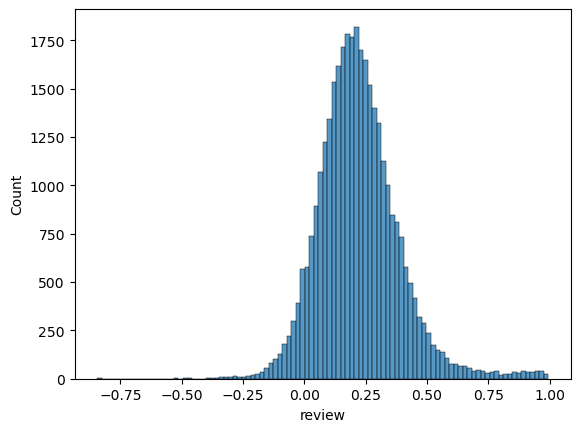

In [36]:
# plot histogram of sentiment scores
sns.histplot(cfm_sents, bins=100)

## expert-like sentiment analysis

In [ ]:
nb_pos = exp_sents[exp_sents > 0.05].shape[0]
nb_neg = exp_sents[exp_sents < -0.05].shape[0]
nb_neu = exp_sents[exp_sents.between(-0.05, 0.05)].shape[0]
nb_pos, nb_neg, nb_neu

(2995, 64, 167)

In [ ]:
# proportion of positive, negative and neutral reviews in percentage
n_ratings = exp_sents.shape[0]
print(f"Positive: {nb_pos/n_ratings*100:.2f}%")
print(f"Negative: {nb_neg/n_ratings*100:.2f}%")
print(f"Neutral: {nb_neu/n_ratings*100:.2f}%")

Positive: 92.84%
Negative: 1.98%
Neutral: 5.18%


<AxesSubplot:xlabel='review', ylabel='Count'>

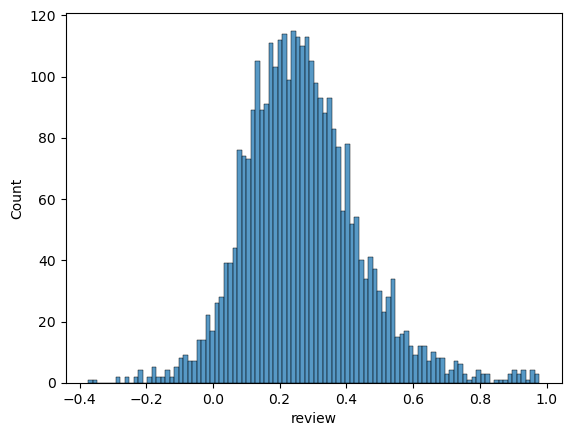

In [ ]:
# plot histogram of sentiment scores
sns.histplot(exp_sents, bins=100)

## explorer sentiment analysis

In [ ]:
nb_pos = xpl_sents[xpl_sents > 0.05].shape[0]
nb_neg = xpl_sents[xpl_sents < -0.05].shape[0]
nb_neu = xpl_sents[xpl_sents.between(-0.05, 0.05)].shape[0]
nb_pos, nb_neg, nb_neu

(68235, 3093, 8367)

In [ ]:
# proportion of positive, negative and neutral reviews in percentage
n_ratings = xpl_sents.shape[0]
print(f"Positive: {nb_pos/n_ratings*100:.2f}%")
print(f"Negative: {nb_neg/n_ratings*100:.2f}%")
print(f"Neutral: {nb_neu/n_ratings*100:.2f}%")

Positive: 85.62%
Negative: 3.88%
Neutral: 10.50%


<AxesSubplot:xlabel='review', ylabel='Count'>

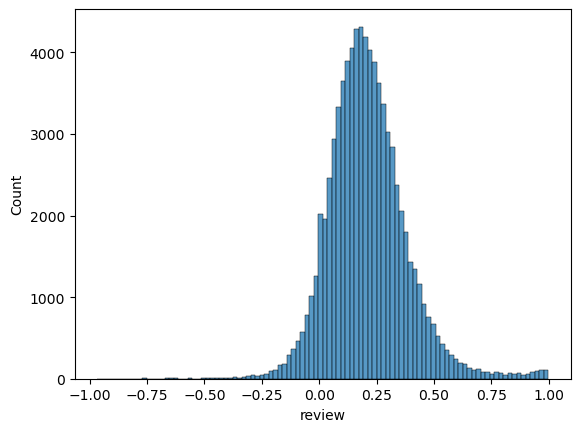

In [ ]:
# plot histogram of sentiment scores
sns.histplot(xpl_sents, bins=100)

## adventurer sentiment analysis

In [ ]:
nb_pos = adv_sents[adv_sents > 0.05].shape[0]
nb_neg = adv_sents[adv_sents < -0.05].shape[0]
nb_neu = adv_sents[adv_sents.between(-0.05, 0.05)].shape[0]
nb_pos, nb_neg, nb_neu

(12070, 865, 1759)

In [ ]:
# proportion of positive, negative and neutral reviews in percentage
n_ratings = adv_sents.shape[0]
print(f"Positive: {nb_pos/n_ratings*100:.2f}%")
print(f"Negative: {nb_neg/n_ratings*100:.2f}%")
print(f"Neutral: {nb_neu/n_ratings*100:.2f}%")

Positive: 82.14%
Negative: 5.89%
Neutral: 11.97%


<AxesSubplot:xlabel='review', ylabel='Count'>

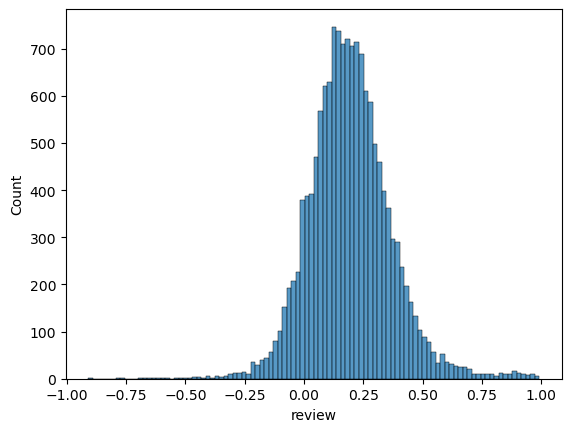

In [ ]:
# plot histogram of sentiment scores
sns.histplot(adv_sents, bins=100)

# sentiment analysis on sample of whole data(regardless of categories)

In [ ]:
nb_pos = overall_sents[overall_sents > 0.05].shape[0]
nb_neg = overall_sents[overall_sents < -0.05].shape[0]
nb_neu = overall_sents[overall_sents.between(-0.05, 0.05)].shape[0]

In [ ]:
# proportion of positive, negative and neutral reviews in percentage
n_ratings = overall_sents.shape[0]
print(f"Positive: {nb_pos/n_ratings*100:.2f}%")
print(f"Negative: {nb_neg/n_ratings*100:.2f}%")
print(f"Neutral: {nb_neu/n_ratings*100:.2f}%")

Positive: 86.79%
Negative: 3.37%
Neutral: 9.84%


<AxesSubplot:xlabel='review', ylabel='Count'>

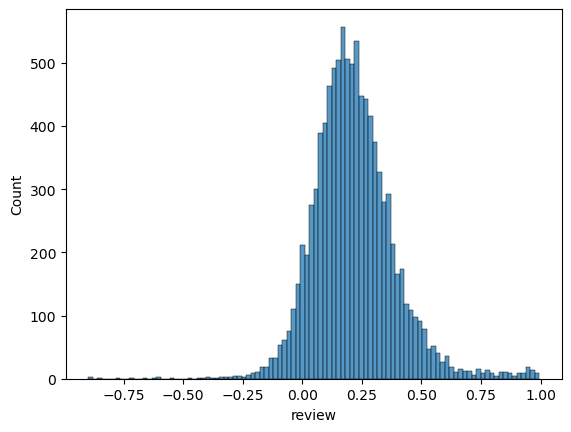

In [ ]:
# plot histogram of sentiment scores
sns.histplot(overall_sents, bins=100)

# summarize for all category using one countplot and one histogram with hue

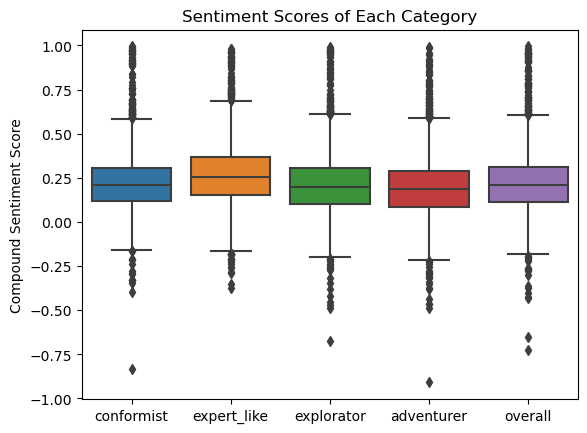

In [8]:
# find min size of category
min_size = min(cfm_sents.shape[0], exp_sents.shape[0], xpl_sents.shape[0])

# sample each category to have the same number of reviews
cfm_sents = cfm_sents.sample(min_size)
exp_sents = exp_sents.sample(min_size)
xpl_sents = xpl_sents.sample(min_size)
adv_sents = adv_sents.sample(min_size)
overall_sents = overall_sents.sample(min_size)


# create dataframe with a column for each category 
sents_df = pd.DataFrame(columns=['conformist', 'expert_like', 'explorator', 'adventurer', 'overall'])
sents_df['conformist'] = cfm_sents.values
sents_df['expert_like'] = exp_sents.values
sents_df['explorator'] = xpl_sents.values
sents_df['adventurer'] = adv_sents.values
sents_df['overall'] = overall_sents.values


# set title
plt.title("Sentiment Scores of Each Category")

# set y axis label
plt.ylabel("Compound Sentiment Score")

# plot boxplot of sentiment scores of each category
sns.boxplot(data=sents_df)

# save figure as svg
plt.savefig("sentiment_scores.svg", transparent=True)


In [11]:
# create dataframe with a column for each category using cfm_sentd, exp_sents, xpl_sents, adv_sents and overall_sents
# with two columns: category and sentiment score
sents_df = pd.DataFrame(columns=['category', 'sentiment_score'])
sents_df['category'] = ['CFM'] * cfm_sents.shape[0] + ['EXP'] * exp_sents.shape[0] + ['XPL'] * xpl_sents.shape[0] + ['ADV'] * adv_sents.shape[0] + ['ALL'] * overall_sents.shape[0]
sents_df['sentiment_score'] = cfm_sents.values.tolist() + exp_sents.values.tolist() + xpl_sents.values.tolist() + adv_sents.values.tolist() + overall_sents.values.tolist()


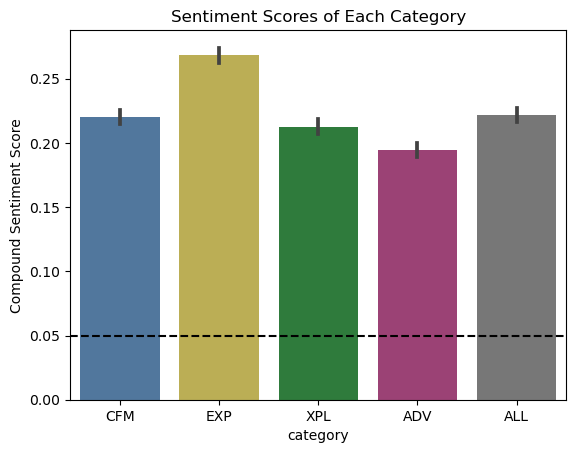

In [13]:
# different colors for each category
#ax = sns.barplot(x='category', y='sentiment_score', data=sents_df, palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax = sns.barplot(x='category', y='sentiment_score', data=sents_df, palette=['#4477AA', '#CCBB44', '#228833', '#AA3377', '#777777'])

# set title
plt.title("Sentiment Scores of Each Category")

# set y axis label
plt.ylabel("Compound Sentiment Score")

# set lines
ax.axhline(0.05, ls='--', color='black')

# save figure as svg
plt.savefig("./plots/sentiment_scores.svg", transparent=True)

Analysis: Sentiment of review is mostly very positive for each category. The average sentiment is significantly above the threshold for positive sentiment. Conformist, explorers have the same average sentiment as the general user. However, expert-like are slighly more postive and adventurers slightly more negative compared to the general user.  
This can be easily explained by looking at the mean rating for each category ie. 4.39 for exp users and 3.45 for adventurers, while conformist and explorers have the same mean rating as the general user.  
The average rating of 3.45 for adventurers is not surprising because by definition they rate beers which are already rated badly by other users. However, the sentiment analyis show that they are not very negative in their reviews. Indeed, while the difference of average rating is huge between adventurers and the general user, the difference of average sentiment is not that noticeable. 

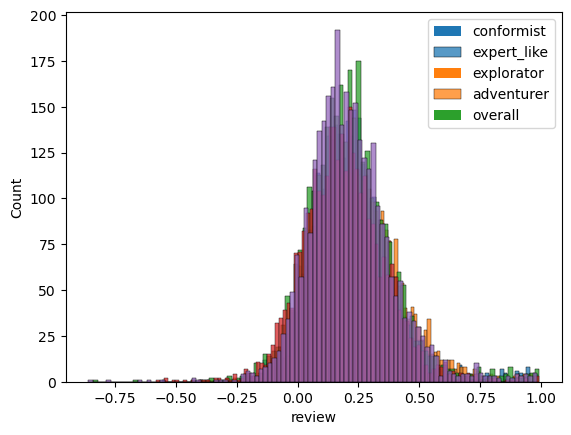

In [ ]:
# superimpose the histograms of each category
sns.histplot(cfm_sents, bins=100)
sns.histplot(exp_sents, bins=100)
sns.histplot(xpl_sents, bins=100)
sns.histplot(adv_sents, bins=100, label='adventurer')
sns.histplot(overall_sents, bins=100, label='overall')

# legends as categories
plt.legend(['conformist', 'expert_like', 'explorator', 'adventurer', 'overall'])



<AxesSubplot:>

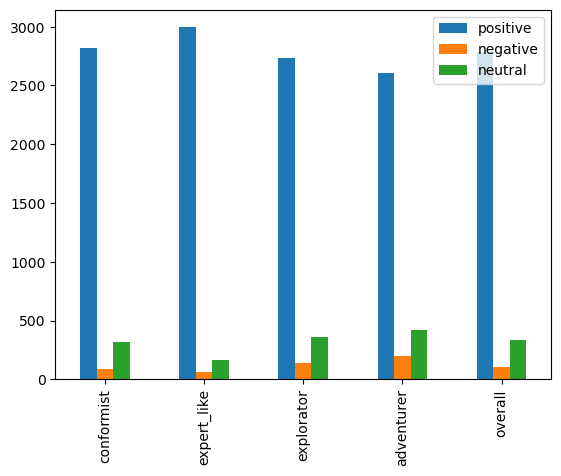

In [ ]:
# count number of positive, negative and neutral reviews in each category
nb_pos = sents_df[sents_df > 0.05].count()
nb_neg = sents_df[sents_df < -0.05].count()

# compute number of neutral reviews (sents_df is a dataframe, so we need to use .values to get the numpy array)
nb_neu = (sents_df.values > -0.05) & (sents_df.values < 0.05)
nb_neu = nb_neu.sum(axis=0)

# create dataframe with the number of positive, negative and neutral reviews in each category
nb_sents = pd.DataFrame({'positive': nb_pos, 'negative': nb_neg, 'neutral': nb_neu})

# plot barplot of number of positive, negative and neutral reviews in each category
nb_sents.plot.bar()
